Generated asymmetric marker positions:
 [[-0.06021824 -2.34595221  3.23062821]
 [ 0.01944483 -4.20660957  0.80212607]
 [ 2.24408735  0.35545859  0.18904501]
 [-1.5413232   1.91703018  3.63331963]
 [-0.29249016  1.06922622  3.25379608]
 [-0.17293926 -3.3817937   0.04350049]]


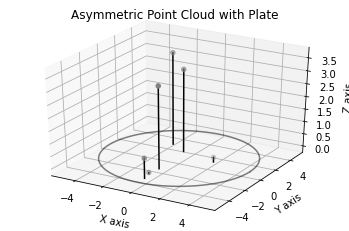

In [27]:
import numpy as np
from scipy.spatial import KDTree
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate random unit vectors
def generate_random_unit_vectors(n):
    vecs = np.random.randn(n, 3)
    vecs /= np.linalg.norm(vecs, axis=1, keepdims=True)
    return vecs

# Reflect across a plane defined by a unit normal
def reflect_across_plane(points, normal):
    normal = normal / np.linalg.norm(normal)
    return points - 2 * np.outer(np.dot(points, normal), normal)

# Rotational symmetry check
def is_rotationally_symmetric(points, num_axes=100, angles=[np.pi, 2*np.pi/3, np.pi/2], tolerance=1e-4):
    points = points - np.mean(points, axis=0)
    tree = KDTree(points)
    axes = generate_random_unit_vectors(num_axes)
    
    for axis in axes:
        for theta in angles:
            rot = R.from_rotvec(theta * axis)
            rotated = rot.apply(points)
            distances, _ = tree.query(rotated)
            if np.all(distances < tolerance):
                return True
    return False

# Reflectional symmetry check
def is_reflectionally_symmetric(points, num_tests=1000, tolerance=1e-4):
    points = points - np.mean(points, axis=0)
    tree = KDTree(points)
    normals = generate_random_unit_vectors(num_tests)

    for normal in normals:
        reflected = reflect_across_plane(points, normal)
        distances, _ = tree.query(reflected)
        if np.all(distances < tolerance):
            return True
    return False

# Combine both checks
def is_symmetric(points):
    return is_reflectionally_symmetric(points) or is_rotationally_symmetric(points)

# Generate asymmetric point cloud
def generate_asymmetric_point_cloud(num_points, radius, max_attempts=10000):
    for attempt in range(max_attempts):
        # Generate random points in a half-sphere (z > 0)
        phi = np.random.uniform(0, 2 * np.pi, num_points)
        costheta = np.random.uniform(0, 1, num_points)  # to ensure z > 0
        u = np.random.uniform(0, 1, num_points)

        theta = np.arccos(costheta)
        r = radius * np.cbrt(u)

        x = r * np.sin(theta) * np.cos(phi)
        y = r * np.sin(theta) * np.sin(phi)
        z = r * np.cos(theta)

        points = np.stack((x, y, z), axis=-1)

        if not is_symmetric(points):
            return points

    raise RuntimeError("Failed to generate asymmetric point cloud after many attempts.")

# Visualization
def plot_points(points, radius):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='grey', marker='o')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

    # draw lines from each point to the base plate
    for point in points:
        ax.plot([point[0], point[0]], [point[1], point[1]], [point[2], 0], 'k')

    # draw circular plate at z=0
    u = np.linspace(0, 2 * np.pi, 100)
    x = radius * np.cos(u)
    y = radius * np.sin(u)
    z = np.zeros_like(x)
    ax.plot(x, y, z, color='black', alpha=0.5)

    ax.set_title('Asymmetric Point Cloud with Plate')
    plt.show()


num_points = 6       # change as needed
radius = 5           # radius in meters or whatever unit you use

points = generate_asymmetric_point_cloud(num_points, radius)
print("Generated asymmetric marker positions:\n", points)
plot_points(points, radius)
